### Denoising Autoencoders And Where To Find Them (10 pts)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py
!pip install Image Pillow==5.1.0 scipy==1.1.0

import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cuda:0") # or you print here you favorite gpu card
# torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

--2022-12-11 09:59:20--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.98K  --.-KB/s    in 0s      

2022-12-11 09:59:20 (44.3 MB/s) - ‘lfw_dataset.py’ saved [3056/3056]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda:0


In [2]:
BATCH_SIZE = 32

In [4]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 255.0  # 255 is the max value for X not 256

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [5]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [6]:
print(img_shape)

(3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


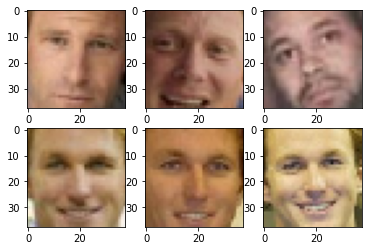

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [8]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [9]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [10]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [11]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [12]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:04, 87.58it/s] 


1, Train loss: 0.10651010278567274, Test loss: 0.024414985960934853


370it [00:01, 333.59it/s]


2, Train loss: 0.023534184305263044, Test loss: 0.02350929606367263


370it [00:01, 334.48it/s]


3, Train loss: 0.023149135473605344, Test loss: 0.023477085972087024


370it [00:01, 338.84it/s]


4, Train loss: 0.02292517040024714, Test loss: 0.0229101777312224


370it [00:01, 330.40it/s]


5, Train loss: 0.022682939158280003, Test loss: 0.022799552860429267


370it [00:01, 337.52it/s]


6, Train loss: 0.022298261328759745, Test loss: 0.02225614468525706


370it [00:01, 337.98it/s]


7, Train loss: 0.021469169622053117, Test loss: 0.0211392292064006


370it [00:01, 339.90it/s]


8, Train loss: 0.01995615001213647, Test loss: 0.01931888460782617


370it [00:01, 338.07it/s]


9, Train loss: 0.018140707472184547, Test loss: 0.017629064091115493


370it [00:01, 337.81it/s]


10, Train loss: 0.016738055010938644, Test loss: 0.015896973500381203


370it [00:01, 337.79it/s]


11, Train loss: 0.015189193306444413, Test loss: 0.014530540010073907


370it [00:01, 335.05it/s]


12, Train loss: 0.01384225567648448, Test loss: 0.01358109396452519


370it [00:01, 337.60it/s]


13, Train loss: 0.012788808011961963, Test loss: 0.012149027064694689


370it [00:01, 333.34it/s]


14, Train loss: 0.011813013309329143, Test loss: 0.01142238282877769


370it [00:01, 324.32it/s]


15, Train loss: 0.010995974394321765, Test loss: 0.010884170955635887


370it [00:01, 336.99it/s]


16, Train loss: 0.010242818811139963, Test loss: 0.009825660052425017


370it [00:01, 339.51it/s]


17, Train loss: 0.009610075992143932, Test loss: 0.009291073053997003


370it [00:01, 339.64it/s]


18, Train loss: 0.009214114763814351, Test loss: 0.00890085421292713


370it [00:01, 332.36it/s]


19, Train loss: 0.008754040516170646, Test loss: 0.008885603848719725


370it [00:01, 320.84it/s]


20, Train loss: 0.00838997864049737, Test loss: 0.008739853469868383


370it [00:01, 334.08it/s]


21, Train loss: 0.008079366135037439, Test loss: 0.008184105793866366


370it [00:01, 332.13it/s]


22, Train loss: 0.007881924193385554, Test loss: 0.007794399946261478


370it [00:01, 337.49it/s]


23, Train loss: 0.007617093942134863, Test loss: 0.0075145374554309126


370it [00:01, 338.28it/s]


24, Train loss: 0.007327278377020583, Test loss: 0.0071543793460548495


370it [00:01, 338.87it/s]


25, Train loss: 0.007146461836018373, Test loss: 0.00714323616166368


370it [00:01, 336.30it/s]


26, Train loss: 0.007058397202146904, Test loss: 0.006956641385593093


370it [00:01, 341.46it/s]


27, Train loss: 0.0069387645488437205, Test loss: 0.007213067396741414


370it [00:01, 331.50it/s]


28, Train loss: 0.006775520586325332, Test loss: 0.006912887510169527


370it [00:01, 330.19it/s]


29, Train loss: 0.006686962715198529, Test loss: 0.006894452869590612


370it [00:01, 325.85it/s]


30, Train loss: 0.006606735774007286, Test loss: 0.006465611390203736


370it [00:01, 333.08it/s]


31, Train loss: 0.00647208652472886, Test loss: 0.006565793727105978


370it [00:01, 339.08it/s]


32, Train loss: 0.006386714317170337, Test loss: 0.006320993389079677


370it [00:01, 335.86it/s]


33, Train loss: 0.006345837808035841, Test loss: 0.006547341126507481


370it [00:01, 335.78it/s]


34, Train loss: 0.00630021675740408, Test loss: 0.006368899023445422


370it [00:01, 331.81it/s]


35, Train loss: 0.006179138544914146, Test loss: 0.006214255686979955


370it [00:01, 330.90it/s]


36, Train loss: 0.006108669894532667, Test loss: 0.006084534894783785


370it [00:01, 337.00it/s]


37, Train loss: 0.006094236880400809, Test loss: 0.006231351830649621


370it [00:01, 328.12it/s]


38, Train loss: 0.006029856870259189, Test loss: 0.006010624119032539


370it [00:01, 333.79it/s]


39, Train loss: 0.005987867758995884, Test loss: 0.005981019986217357


370it [00:01, 335.51it/s]


40, Train loss: 0.005972135859817158, Test loss: 0.006507590732983757


In [13]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.006462845786125608


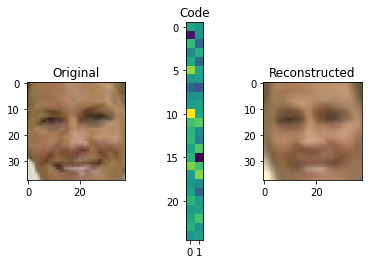

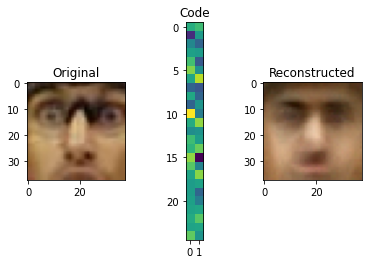

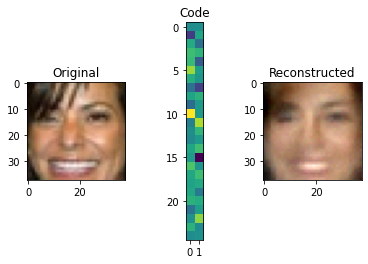

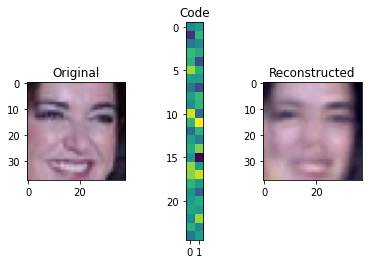

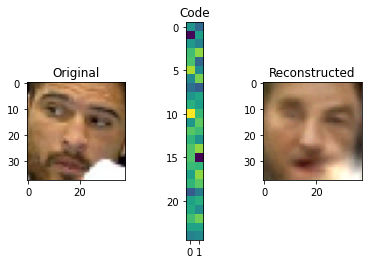

In [14]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [30]:
class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        self.enc = nn.Sequential(
            Reshape(-1, np.prod(img_shape)),
            # nn.Flatten(),
            nn.Linear(np.prod(img_shape), 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, code_size)
        )
        self.dec = nn.Sequential(
            nn.Linear(code_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, np.prod(img_shape)),
            nn.Sigmoid(),
            Reshape(-1, *img_shape)
        )
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [36]:
class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=2), # 38x38 => 19x19
            nn.ReLU(True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2), # 19x19 => 10x10
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=2), # 10x10 => 5x5
            nn.ReLU(True),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(5 * 5 * 32, code_size)
        )
        self.dec = nn.Sequential(
            nn.Linear(code_size, 5 * 5 * 32),
            nn.ReLU(True),
            Reshape(-1, 32, 5, 5),
            nn.ConvTranspose2d(32, 32, kernel_size=3, output_padding=1, padding=1, stride=2), # 5x5 => 10x10
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, output_padding=0, padding=1, stride=2), # 10x10 => 19x19
            nn.ReLU(True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, output_padding=1, padding=1, stride=2), # 19x19 => 38x38
            nn.Sigmoid() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [31]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = DeepAutoencoder(code_size).float().to(device)
    encoder_out = model.enc(help_tensor.float().cuda(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)
    print(help_tensor.shape, decoder_out.shape)
    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    # assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
torch.Size([32, 3, 38, 38]) torch.Size([32, 3, 38, 38])
Testing code size 8
torch.Size([32, 3, 38, 38]) torch.Size([32, 3, 38, 38])
Testing code size 32
torch.Size([32, 3, 38, 38]) torch.Size([32, 3, 38, 38])
Testing code size 128
torch.Size([32, 3, 38, 38]) torch.Size([32, 3, 38, 38])
Testing code size 512
torch.Size([32, 3, 38, 38]) torch.Size([32, 3, 38, 38])
Testing code size 1024
torch.Size([32, 3, 38, 38]) torch.Size([32, 3, 38, 38])
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [37]:
aenc_deep = DeepAutoencoder()
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=150)

370it [00:09, 39.08it/s]


1, Train loss: 0.031790406358115704, Test loss: 0.020718280426280114


370it [00:05, 69.67it/s]


2, Train loss: 0.013979471052805687, Test loss: 0.01163763345176629


370it [00:05, 70.22it/s]


3, Train loss: 0.010725275081230527, Test loss: 0.010191439782908004


370it [00:05, 70.20it/s]


4, Train loss: 0.00969539637038899, Test loss: 0.00928372210388978


370it [00:05, 70.18it/s]


5, Train loss: 0.008941099790973796, Test loss: 0.008641722408083067


370it [00:05, 69.67it/s]


6, Train loss: 0.00833777590133687, Test loss: 0.008148882453706444


370it [00:05, 69.47it/s]


7, Train loss: 0.007923388135231234, Test loss: 0.007890827170667105


370it [00:05, 69.33it/s]


8, Train loss: 0.007643630084809008, Test loss: 0.007533776305539959


370it [00:07, 48.61it/s]


9, Train loss: 0.007367397478749769, Test loss: 0.007303234401726732


370it [00:05, 65.51it/s]


10, Train loss: 0.007106276152870788, Test loss: 0.007088471134277123


370it [00:05, 70.39it/s]


11, Train loss: 0.006898799309547204, Test loss: 0.00683117719084977


370it [00:05, 70.28it/s]


12, Train loss: 0.006762126454765701, Test loss: 0.006747422737324359


370it [00:05, 66.19it/s]


13, Train loss: 0.006625776968126603, Test loss: 0.006651887309168582


370it [00:05, 68.01it/s]


14, Train loss: 0.006510866062925648, Test loss: 0.006515528098185491


370it [00:05, 62.96it/s]


15, Train loss: 0.006405958490293183, Test loss: 0.006436809453404825


370it [00:06, 60.96it/s]


16, Train loss: 0.006324408617748613, Test loss: 0.006312721751168278


370it [00:05, 64.57it/s]


17, Train loss: 0.0062163261973737305, Test loss: 0.006300878946690244


370it [00:05, 62.09it/s]


18, Train loss: 0.00615277035356618, Test loss: 0.006287101180294708


370it [00:05, 62.94it/s]


19, Train loss: 0.006088315562308759, Test loss: 0.006196485514024552


370it [00:05, 69.93it/s]


20, Train loss: 0.006000764609256019, Test loss: 0.006141916019837844


370it [00:05, 69.83it/s]


21, Train loss: 0.00596372189339362, Test loss: 0.006434057949117381


370it [00:05, 69.96it/s]


22, Train loss: 0.005919617160683974, Test loss: 0.0059995854832878785


370it [00:05, 70.27it/s]


23, Train loss: 0.005852406243843028, Test loss: 0.005981558121094539


370it [00:05, 69.83it/s]


24, Train loss: 0.005828964203244253, Test loss: 0.005889946018438958


370it [00:05, 69.66it/s]


25, Train loss: 0.005787868405590137, Test loss: 0.005884666056028494


370it [00:05, 70.10it/s]


26, Train loss: 0.005746671804159562, Test loss: 0.005850751863711099


370it [00:05, 66.73it/s]


27, Train loss: 0.0057122623329188054, Test loss: 0.00577901851440025


370it [00:05, 70.13it/s]


28, Train loss: 0.005669172338373042, Test loss: 0.005914503998496508


370it [00:05, 69.93it/s]


29, Train loss: 0.005622246431554781, Test loss: 0.006183156004282239


370it [00:05, 70.06it/s]


30, Train loss: 0.005601104268381415, Test loss: 0.0056761099864742716


370it [00:05, 70.50it/s]


31, Train loss: 0.005553518543297441, Test loss: 0.005697357002310437


370it [00:05, 69.86it/s]


32, Train loss: 0.005539011764655914, Test loss: 0.00573713367283938


370it [00:05, 69.96it/s]


33, Train loss: 0.005515870006667512, Test loss: 0.005722196480547338


370it [00:05, 70.53it/s]


34, Train loss: 0.005499959002054004, Test loss: 0.005672753264873542


370it [00:05, 70.15it/s]


35, Train loss: 0.005472237333222513, Test loss: 0.005773348731283271


370it [00:05, 69.50it/s]


36, Train loss: 0.00546163294617998, Test loss: 0.0056128368266459856


370it [00:05, 65.65it/s]


37, Train loss: 0.005433886715626884, Test loss: 0.0055639252093771


370it [00:05, 69.43it/s]


38, Train loss: 0.005411965099494067, Test loss: 0.0055220588284745405


370it [00:05, 69.69it/s]


39, Train loss: 0.005384269169592716, Test loss: 0.005586994802899076


370it [00:05, 69.94it/s]


40, Train loss: 0.005380479907081152, Test loss: 0.005556063989365169


370it [00:05, 69.89it/s]


41, Train loss: 0.005368442279899107, Test loss: 0.005493992936438516


370it [00:05, 69.81it/s]


42, Train loss: 0.0053468150629600465, Test loss: 0.005518305604446533


370it [00:05, 69.47it/s]


43, Train loss: 0.0053314737189127355, Test loss: 0.005567277239134085


370it [00:05, 63.13it/s]


44, Train loss: 0.005307216237882132, Test loss: 0.0054899716421525175


370it [00:05, 70.34it/s]


45, Train loss: 0.005301812586210167, Test loss: 0.0054600814777439905


370it [00:05, 69.94it/s]


46, Train loss: 0.005278124470490056, Test loss: 0.005682540068545289


370it [00:05, 69.60it/s]


47, Train loss: 0.005275820973323999, Test loss: 0.0054481160536326454


370it [00:05, 69.81it/s]


48, Train loss: 0.005256441911501874, Test loss: 0.0054810556856040565


370it [00:05, 70.08it/s]


49, Train loss: 0.005251122867007143, Test loss: 0.005393057111368979


370it [00:05, 69.89it/s]


50, Train loss: 0.005223902065786261, Test loss: 0.00539813009071161


370it [00:05, 70.51it/s]


51, Train loss: 0.005215376436458543, Test loss: 0.005435124374356314


370it [00:05, 69.25it/s]


52, Train loss: 0.005209021977171344, Test loss: 0.005399937930924508


370it [00:05, 70.74it/s]


53, Train loss: 0.005200339089845211, Test loss: 0.005413557918660912


370it [00:05, 69.34it/s]


54, Train loss: 0.005186518522776809, Test loss: 0.0054202838819513875


370it [00:05, 70.41it/s]


55, Train loss: 0.00517322436213958, Test loss: 0.0054190161971819735


370it [00:05, 69.86it/s]


56, Train loss: 0.005174299300389886, Test loss: 0.00537522869441629


370it [00:05, 69.74it/s]


57, Train loss: 0.005156571747335801, Test loss: 0.005383855987322893


370it [00:05, 69.96it/s]


58, Train loss: 0.005131690761362638, Test loss: 0.005385669775923323


370it [00:05, 69.78it/s]


59, Train loss: 0.005133464317283081, Test loss: 0.005329249661849529


370it [00:05, 69.50it/s]


60, Train loss: 0.005113541738334713, Test loss: 0.005378566526172313


370it [00:05, 69.83it/s]


61, Train loss: 0.005125032403554516, Test loss: 0.0053190737765271955


370it [00:05, 70.18it/s]


62, Train loss: 0.005105720495634898, Test loss: 0.005339352578520069


370it [00:05, 69.96it/s]


63, Train loss: 0.005097266487696006, Test loss: 0.005333480710727933


370it [00:05, 69.80it/s]


64, Train loss: 0.005095681384130804, Test loss: 0.005421604722870009


370it [00:05, 69.65it/s]


65, Train loss: 0.005089813237944233, Test loss: 0.005350327286928804


370it [00:05, 69.93it/s]


66, Train loss: 0.005081862957787725, Test loss: 0.005276313756639027


370it [00:05, 69.81it/s]


67, Train loss: 0.005063506432100509, Test loss: 0.005341600933939786


370it [00:05, 70.27it/s]


68, Train loss: 0.005063571960655615, Test loss: 0.005321258218124376


370it [00:05, 69.76it/s]


69, Train loss: 0.005051401271794791, Test loss: 0.005280140504285255


370it [00:05, 69.23it/s]


70, Train loss: 0.005033526372227723, Test loss: 0.005254769091597879


370it [00:05, 68.69it/s]


71, Train loss: 0.005039416485186964, Test loss: 0.005298123087930809


370it [00:05, 69.35it/s]


72, Train loss: 0.005026802588968609, Test loss: 0.005335799995952344


370it [00:05, 69.95it/s]


73, Train loss: 0.005027089318645733, Test loss: 0.005346891946595262


370it [00:05, 69.54it/s]


74, Train loss: 0.005009630360754284, Test loss: 0.005251129065803407


370it [00:05, 68.25it/s]


75, Train loss: 0.005013000265005003, Test loss: 0.005321086388724726


370it [00:05, 64.46it/s]


76, Train loss: 0.004995982190137723, Test loss: 0.005330560647669643


370it [00:05, 69.90it/s]


77, Train loss: 0.0049965173803076905, Test loss: 0.00535038137222545


370it [00:05, 69.59it/s]


78, Train loss: 0.00498445859487524, Test loss: 0.005394827502928696


370it [00:05, 69.74it/s]


79, Train loss: 0.004987305612373843, Test loss: 0.005320967243996654


370it [00:05, 69.47it/s]


80, Train loss: 0.004970151464404864, Test loss: 0.005287034786962229


370it [00:05, 69.19it/s]


81, Train loss: 0.004977438840102275, Test loss: 0.005185481286922528


370it [00:05, 69.91it/s]


82, Train loss: 0.004947542427113135, Test loss: 0.0052438614994198334


370it [00:05, 70.26it/s]


83, Train loss: 0.004961392110032348, Test loss: 0.0052586123311662595


370it [00:05, 70.05it/s]


84, Train loss: 0.004953494097193999, Test loss: 0.005263875463603771


370it [00:05, 70.13it/s]


85, Train loss: 0.0049458260160397385, Test loss: 0.0052501888313208804


370it [00:05, 70.17it/s]


86, Train loss: 0.0049491916599376795, Test loss: 0.005337943886683004


370it [00:05, 69.89it/s]


87, Train loss: 0.004950023112269031, Test loss: 0.005306878104822252


370it [00:06, 61.41it/s]


88, Train loss: 0.004936433341069465, Test loss: 0.00526191539776733


370it [00:05, 69.78it/s]


89, Train loss: 0.004937029232293178, Test loss: 0.005265154220488272


370it [00:05, 68.26it/s]


90, Train loss: 0.00493164642385072, Test loss: 0.005408818073489934


370it [00:05, 69.92it/s]


91, Train loss: 0.0049067286081490346, Test loss: 0.0052572441682430205


107it [00:01, 68.83it/s]


KeyboardInterrupt: ignored

Training may take long, it's okay.

Final MSE: 0.005206998446705945


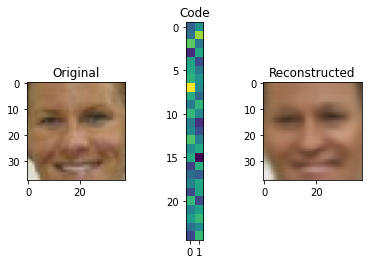

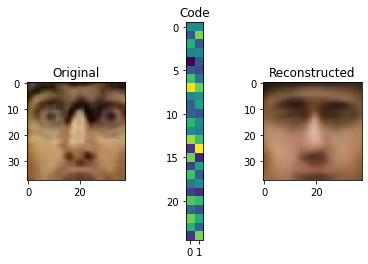

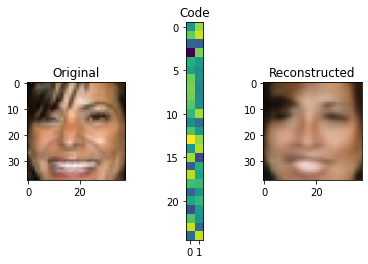

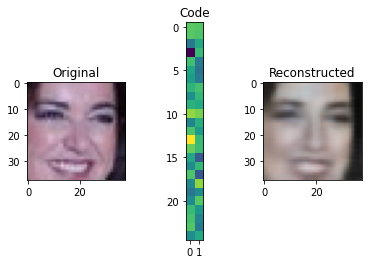

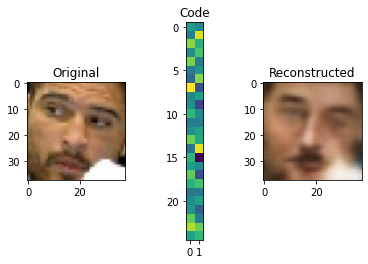

In [38]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [39]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = torch.randn_like(X) * sigma
        
    return X + noise
    

In [40]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

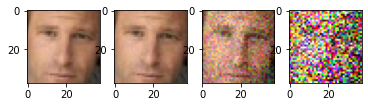

In [42]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1));

In [43]:
aenc = DeepAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:08, 44.47it/s]


1, Train loss: 0.03223466674422842, Test loss: 0.017514056614656742


370it [00:08, 45.42it/s]


2, Train loss: 0.013879503461152139, Test loss: 0.012635875227354607


370it [00:09, 40.56it/s]


3, Train loss: 0.011139403690944951, Test loss: 0.010708635344187107


370it [00:08, 44.71it/s]


4, Train loss: 0.010032600326310087, Test loss: 0.009762775276727012


370it [00:08, 45.44it/s]


5, Train loss: 0.009178879770719016, Test loss: 0.008785635943090883


370it [00:08, 45.43it/s]


6, Train loss: 0.008602800969087531, Test loss: 0.008405053723513087


370it [00:08, 45.27it/s]


7, Train loss: 0.008195418213898457, Test loss: 0.008199151913161321


370it [00:08, 45.31it/s]


8, Train loss: 0.007840499470618587, Test loss: 0.007639429446134298


370it [00:08, 45.15it/s]


9, Train loss: 0.0074942641089645445, Test loss: 0.00794080670955898


370it [00:08, 45.00it/s]


10, Train loss: 0.007227562030430556, Test loss: 0.007336839564046003


370it [00:09, 39.54it/s]


11, Train loss: 0.007023061334048865, Test loss: 0.006954277147321033


370it [00:08, 42.37it/s]


12, Train loss: 0.006848516596640045, Test loss: 0.006831089622004875


370it [00:08, 45.64it/s]


13, Train loss: 0.006712090952113755, Test loss: 0.006664566107087828


370it [00:08, 45.14it/s]


14, Train loss: 0.006575274774024811, Test loss: 0.006607309740100706


370it [00:08, 45.36it/s]


15, Train loss: 0.0064943105884854, Test loss: 0.00639805157441226


370it [00:08, 45.18it/s]


16, Train loss: 0.006385491302335547, Test loss: 0.006452932624006154


370it [00:08, 45.42it/s]


17, Train loss: 0.006335564251541799, Test loss: 0.006291938132130609


370it [00:08, 45.42it/s]


18, Train loss: 0.006247019110210458, Test loss: 0.006196640137066586


370it [00:09, 37.50it/s]


19, Train loss: 0.006190813709378019, Test loss: 0.006089273479161626


370it [00:08, 45.00it/s]


20, Train loss: 0.0061143337054189156, Test loss: 0.006123779299330458


370it [00:08, 45.24it/s]


21, Train loss: 0.006046854454522025, Test loss: 0.005974244272995748


370it [00:08, 45.34it/s]


22, Train loss: 0.006009237863643083, Test loss: 0.006147961109157989


370it [00:09, 40.70it/s]


23, Train loss: 0.0059820745772813455, Test loss: 0.005986734920054185


370it [00:08, 44.93it/s]


24, Train loss: 0.0059440137907707255, Test loss: 0.0059347496214271055


370it [00:08, 45.03it/s]


25, Train loss: 0.005890509237906405, Test loss: 0.005921383213515901


370it [00:08, 42.25it/s]


26, Train loss: 0.005860217647949236, Test loss: 0.005774663378267045


370it [00:08, 43.59it/s]


27, Train loss: 0.005818991343829803, Test loss: 0.005819575273205031


370it [00:08, 44.98it/s]


28, Train loss: 0.005782652636103883, Test loss: 0.005768370026878687


370it [00:08, 44.95it/s]


29, Train loss: 0.005762546296911943, Test loss: 0.0057252550647713596


370it [00:08, 45.14it/s]


30, Train loss: 0.005728190038436988, Test loss: 0.0057167186490740315


370it [00:08, 45.03it/s]


31, Train loss: 0.005702469521612099, Test loss: 0.005822353369693335


370it [00:08, 45.07it/s]


32, Train loss: 0.005677249105908563, Test loss: 0.005716979759881027


370it [00:08, 45.35it/s]


33, Train loss: 0.005648108593933507, Test loss: 0.00572158191948604


370it [00:08, 45.16it/s]


34, Train loss: 0.005633182396668401, Test loss: 0.005722558619742932


370it [00:08, 45.06it/s]


35, Train loss: 0.005603039886490007, Test loss: 0.005627853069818384


370it [00:08, 45.06it/s]


36, Train loss: 0.005594984091566335, Test loss: 0.005592085459690664


370it [00:08, 44.59it/s]


37, Train loss: 0.005558630244394812, Test loss: 0.005550623973063688


370it [00:08, 45.13it/s]


38, Train loss: 0.005539877486656922, Test loss: 0.005510839944329368


370it [00:08, 45.25it/s]


39, Train loss: 0.00553057273281273, Test loss: 0.005737449069573975


370it [00:08, 45.47it/s]


40, Train loss: 0.005504882199868597, Test loss: 0.005551878104826697


370it [00:08, 45.14it/s]


41, Train loss: 0.005503555601132011, Test loss: 0.0055871615266346476


370it [00:08, 44.87it/s]


42, Train loss: 0.005486516506859117, Test loss: 0.0055606158683032415


370it [00:08, 44.60it/s]


43, Train loss: 0.005473060944045872, Test loss: 0.0056863623734841875


370it [00:09, 40.75it/s]


44, Train loss: 0.0054576219811025865, Test loss: 0.005528630127063465


370it [00:08, 44.93it/s]


45, Train loss: 0.0054430809198661185, Test loss: 0.005451513350252446


370it [00:08, 44.86it/s]


46, Train loss: 0.00541911569269613, Test loss: 0.005585240541443844


370it [00:08, 44.92it/s]


47, Train loss: 0.005421115248589777, Test loss: 0.00556927716990211


370it [00:08, 45.14it/s]


48, Train loss: 0.005415358957603207, Test loss: 0.005535805433193786


370it [00:08, 45.10it/s]


49, Train loss: 0.005400470711715841, Test loss: 0.005434927395871493


370it [00:08, 44.66it/s]


50, Train loss: 0.00539429918260135, Test loss: 0.0054460913384385455


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.005531149723870795


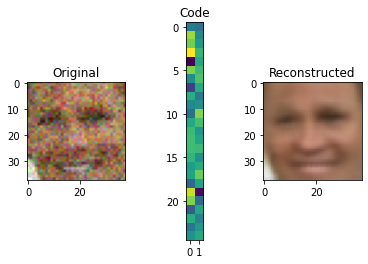

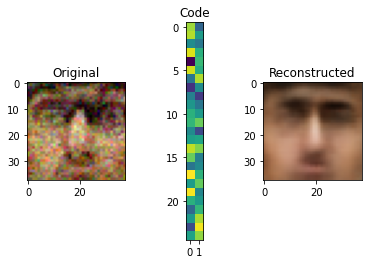

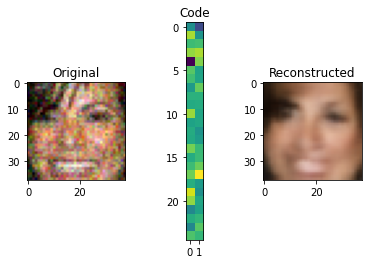

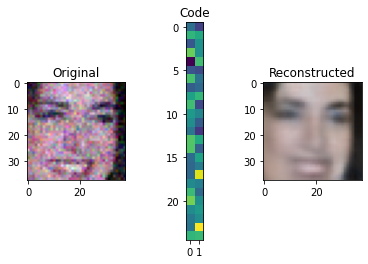

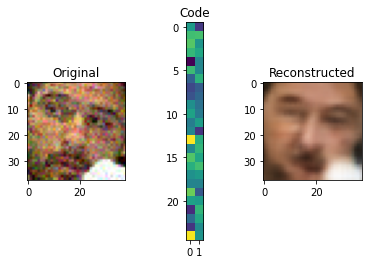

In [46]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [53]:
!pip3 install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 11.7 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp38-cp38-linux_x86_64.whl size=396896 sha256=61525baa3942e046127ee8252cfa15bf897755a5ed5e8214bfede4e37900eebc
  Stored in directory: /root/.cache/pip/wheels/f9/93/19/30511c4a9ae6b4937455a134c34a39e13943e2c6f46fcd2ed2
Successfully built annoy


In [54]:
from annoy import AnnoyIndex

In [55]:
index = AnnoyIndex(50, 'angular')

In [ ]:
index.add_item()

In [50]:
#encodes batch of images into a codes

aenc.eval()
codes = aenc.enc(X_train_tensor.double().cuda())


In [51]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [61]:
# LSHForest was deprecated due to inefficiency. Let's use AnnoyIndex from annoy.
# from sklearn.neighbors import LSHForest
# lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())
index = AnnoyIndex(codes.shape[-1], 'angular')
for i, code in enumerate(codes.detach().cpu().numpy()):
    index.add_item(i, code)

index.build(50)

True

In [66]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [81]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"
    code = aenc.enc(image[None].cuda(device))[0].detach().cpu().numpy()
    
    idxs, distances = index.get_nns_by_vector(
        code, n=n_neighbors, include_distances=True
        )
    
    return distances, images[idxs]

In [86]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.tight_layout()
    plt.show()

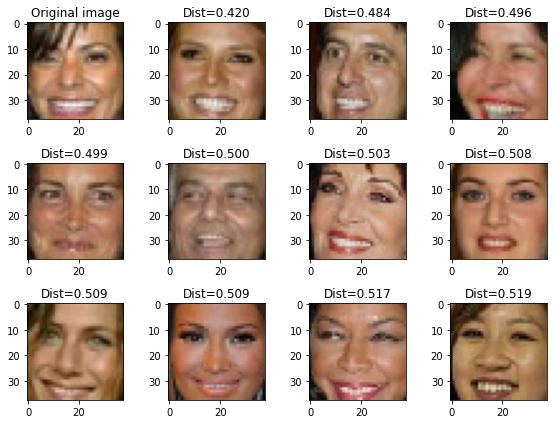

In [87]:
#smiles
show_similar(X_test_tensor[2])

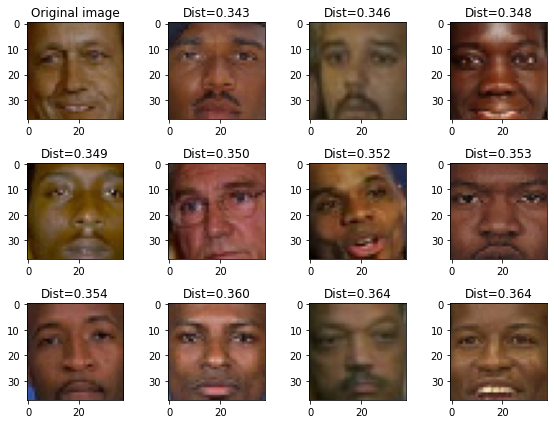

In [88]:
#ethnicity
show_similar(X_test_tensor[500])

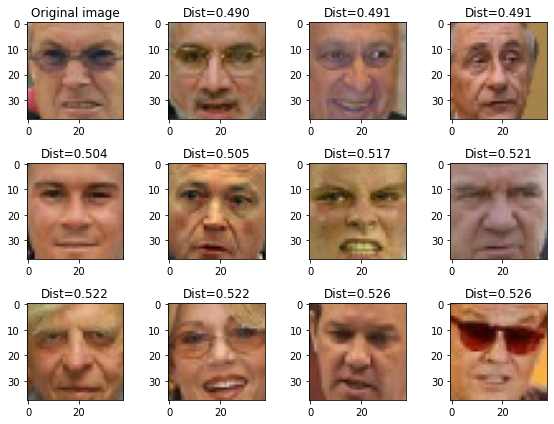

In [89]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


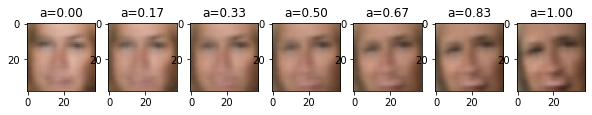

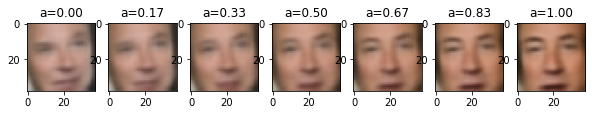

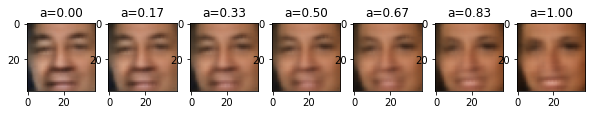

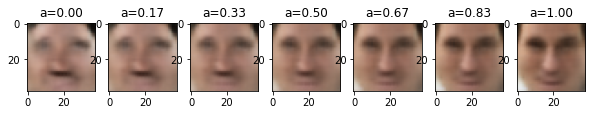

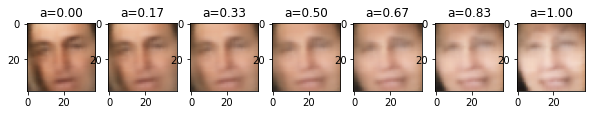

In [94]:
for _ in range(5):
    image1, image2 = X_test_tensor[np.random.randint(0, len(X_test), size=2)]

    image_pair = torch.cat((image1[None], image2[None]), 0).cuda(device)
    # ^-- note: depending on your implementation, you may need to call torch.permute here
    
    
    code1, code2 = aenc.enc(image_pair)

    plt.figure(figsize=[10,4])
    for i, a in enumerate(np.linspace(0, 1, num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().permute(1, 2, 0).numpy())
        plt.title("a=%.2f"%a)
    
    plt.tight_layout()
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.